In [65]:
import numpy as np
import pandas as pd
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Solar.csv')


In [74]:
df.sample(10)

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,month,date,hour,minute,second,riseminute,sethour,setminute,hour_sin,hour_cos,date_str,day_of_year
43143,1480915534,1.21,45.0,30.37,93.0,97.97,2.25,12,4.0,19,25.0,34,43.0,17.0,43.0,-0.965926,2.588190e-01,2020-12-04,339.0
5812,1473226832,2.40,50.0,30.41,100.0,71.93,3.37,9,6.0,19,40.0,32,8.0,18.0,34.0,-0.965926,2.588190e-01,2020-09-06,250.0
12397,1476491420,797.69,64.0,30.45,49.0,101.07,3.37,10,14.0,14,30.0,20,17.0,18.0,0.0,-0.500000,-8.660254e-01,2020-10-14,288.0
8652,1477623017,201.41,53.0,30.38,94.0,80.91,9.00,10,27.0,16,50.0,17,22.0,17.0,51.0,-0.866025,-5.000000e-01,2020-10-27,301.0
40740,1481862905,1.25,47.0,30.24,102.0,315.59,10.12,12,15.0,18,35.0,5,50.0,17.0,46.0,-1.000000,-1.836970e-16,2020-12-15,350.0
5587,1473320428,2.21,49.0,30.45,53.0,150.04,3.37,9,7.0,21,40.0,28,8.0,18.0,33.0,-0.707107,7.071068e-01,2020-09-07,251.0
40832,1481834721,1004.20,53.0,30.28,83.0,292.19,6.75,12,15.0,10,45.0,21,50.0,17.0,46.0,0.500000,-8.660254e-01,2020-12-15,350.0
29360,1480011603,331.67,47.0,30.48,99.0,80.18,3.37,11,24.0,8,20.0,3,37.0,17.0,42.0,0.866025,-5.000000e-01,2020-11-24,329.0
2038,1474602921,26.71,57.0,30.42,86.0,68.83,7.87,9,22.0,17,55.0,21,11.0,18.0,19.0,-0.965926,-2.588190e-01,2020-09-22,266.0
35452,1478182521,1.22,45.0,30.41,38.0,176.14,7.87,11,3.0,4,15.0,21,25.0,17.0,47.0,0.866025,5.000000e-01,2020-11-03,308.0


In [72]:
print("Data Overview:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Data Overview:
     UNIXTime  Radiation  Temperature  Pressure  Humidity  \
0  1475229326       1.21         48.0     30.46      59.0   
1  1475229023       1.21         48.0     30.46      58.0   
2  1475228726       1.23         48.0     30.46      57.0   
3  1475228421       1.21         48.0     30.46      60.0   
4  1475228124       1.17         48.0     30.46      62.0   

   WindDirection(Degrees)  Speed  month  date  hour  minute  second  \
0                  177.39   5.62      9  29.0    23    55.0      26   
1                  176.78   3.37      9  29.0    23    50.0      23   
2                  158.75   3.37      9  29.0    23    45.0      26   
3                  137.71   3.37      9  29.0    23    40.0      21   
4                  104.95   5.62      9  29.0    23    35.0      24   

   riseminute  sethour  setminute  hour_sin  hour_cos    date_str  day_of_year  
0        13.0     18.0       13.0 -0.258819  0.965926  2020-09-29        273.0  
1        13.0     18.0       

In [75]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
           UNIXTime     Radiation   Temperature      Pressure      Humidity  \
count  4.424100e+04  44241.000000  44241.000000  44241.000000  44241.000000   
mean   1.478054e+09    210.799955     51.302660     30.428639     73.590267   
std    2.734611e+06    317.354544      6.187244      0.050395     26.967120   
min    1.472724e+09      1.110000     34.000000     30.190000      8.000000   
25%    1.475873e+09      1.230000     47.000000     30.410000     52.000000   
50%    1.478374e+09      2.540000     50.000000     30.440000     84.000000   
75%    1.480047e+09    368.240000     55.000000     30.460000     97.000000   
max    1.483265e+09   1601.260000     71.000000     30.560000    103.000000   

       WindDirection(Degrees)         Speed         month          date  \
count            44241.000000  44241.000000  44241.000000  44241.000000   
mean               141.164559      6.284085     10.571619     15.303361   
std                 81.998097      3.4095

In [66]:
# Data Preprocessing
# Date and Time Extraction
def extract_from_regex(pattern, string):
    # Convert to string to ensure compatibility with re.search
    string = str(string)
    match = re.search(pattern, string)
    return int(match.group(0)) if match else np.nan  # Return NaN if no match

In [67]:
df['month'] = df['Data'].apply(lambda x: extract_from_regex(r'^\d+', x))
df['date'] = df['Data'].apply(lambda x: extract_from_regex(r'(?<=\/)\d+(?=\/)', x))
df['year'] = df['Data'].apply(lambda x: extract_from_regex(r'(?<=\/)\d+(?=\s)', x))
df['hour'] = df['Time'].apply(lambda x: extract_from_regex(r'^\d+', x))
df['minute'] = df['Time'].apply(lambda x: extract_from_regex(r'(?<=\:)\d+(?=\:)', x))
df['second'] = df['Time'].apply(lambda x: extract_from_regex(r'\d+$', x)) # Fixed the regex pattern here
df['risehour'] = df['TimeSunRise'].apply(lambda x: extract_from_regex(r'^\d+', x))
df['riseminute'] = df['TimeSunRise'].apply(lambda x: extract_from_regex(r'(?<=\:)\d+(?=\:)', x))
df['sethour'] = df['TimeSunSet'].apply(lambda x: extract_from_regex(r'^\d+', x))
df['setminute'] = df['TimeSunSet'].apply(lambda x: extract_from_regex(r'(?<=\:)\d+(?=\:)', x))


In [68]:
# Drop unnecessary columns
df.drop(['Data', 'Time', 'TimeSunRise', 'TimeSunSet', 'year', 'risehour'], axis=1, inplace=True)

# Convert all columns to numeric, coerce errors to NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handling missing values (if any)
df.fillna(df.median(), inplace=True)  # Fill missing values with the median

# Feature Engineering
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # Convert hour to sine wave
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)  # Convert hour to cosine wave

# Create a 'date' column with the correct format 'YYYY-MM-DD'
df['date_str'] = '2020-' + df['month'].astype(int).astype(str).str.zfill(2) + '-' + df['date'].astype(int).astype(str).str.zfill(2)
# Convert 'date_str' to datetime objects, handling errors
df['day_of_year'] = pd.to_datetime(df['date_str'], errors='coerce').dt.dayofyear



In [69]:
# Define target and features
y = df['Radiation'].copy()
X = df.drop(['Radiation', 'date_str'], axis=1).copy() # Exclude 'date_str' from features

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

[I 2024-10-15 10:23:31,322] A new study created in memory with name: no-name-7e471498-c452-42ca-b3ea-557b5d23d3e7


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('lambda', 1e-5, 1.0)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 's

[I 2024-10-15 10:23:31,807] Trial 0 finished with value: 153.76968639197023 and parameters: {'learning_rate': 0.012011766799873877, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.858531367180579, 'colsample_bytree': 0.5197893335234401, 'alpha': 0.00021103062931203973, 'lambda': 0.00852740999274343}. Best is trial 0 with value: 153.76968639197023.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:32,584] Trial 1 finished with value: 311.7521417232432 and parameters: {'learning_rate': 0.00019319683403315862, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.5767235600381999, 'colsample_bytree': 0.8328738491257952, 'alpha': 1.3210846824472474e-05, 'lambda': 0.0004384031856920034}. Best is trial 0 with value: 153.76968639197023.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:33,035] Trial 2 finished with value: 316.69307062151927 and parameters: {'learning_rate': 1.7155413214545867e-05, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5005397735231435, 'colsample_bytree': 0.6629272128036696, 'alpha': 1.544533685251633e-05, 'lambda': 0.003160732591995718}. Best is trial 0 with value: 153.76968639197023.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:33,727] Trial 3 finished with value: 316.6436871603851 and parameters: {'learning_rate': 1.945601693277562e-05, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.6116800161708819, 'colsample_bytree': 0.5115479247156911, 'alpha': 3.165624735684745e-05, 'lambda': 1.1334901905324266e-05}. Best is trial 0 with value: 153.76968639197023.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:34,206] Trial 4 finished with value: 78.15979953206387 and parameters: {'learning_rate': 0.10386235489625271, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5922892474200026, 'colsample_bytree': 0.6025460351936252, 'alpha': 0.006204812234907907, 'lambda': 0.08252877701803342}. Best is trial 4 with value: 78.15979953206387.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:35,191] Trial 5 finished with value: 316.4572992126753 and parameters: {'learning_rate': 2.46220982226718e-05, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7986390387937825, 'colsample_bytree': 0.6737399844391969, 'alpha': 0.6534228516343923, 'lambda': 5.0533861127383185e-05}. Best is trial 4 with value: 78.15979953206387.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:39,096] Trial 6 finished with value: 74.32464924318691 and parameters: {'learning_rate': 0.0275034276044821, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9539285401909317, 'colsample_bytree': 0.8591036545627098, 'alpha': 0.11581982968255525, 'lambda': 0.0001935844407839683}. Best is trial 6 with value: 74.32464924318691.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:39,545] Trial 7 finished with value: 77.74806683199483 and parameters: {'learning_rate': 0.3087095062024717, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6129490892898936, 'colsample_bytree': 0.8299239883787031, 'alpha': 3.125552697642087e-05, 'lambda': 2.583960957888118e-05}. Best is trial 6 with value: 74.32464924318691.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:40,001] Trial 8 finished with value: 316.4662318085603 and parameters: {'learning_rate': 2.573514895524783e-05, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7775928337341151, 'colsample_bytree': 0.6887573178374691, 'alpha': 0.05305105883807997, 'lambda': 6.425191734693727e-05}. Best is trial 6 with value: 74.32464924318691.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:40,753] Trial 9 finished with value: 310.2836198999502 and parameters: {'learning_rate': 0.0002465441051906013, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9444997477162242, 'colsample_bytree': 0.8472531598045849, 'alpha': 0.3223648994430732, 'lambda': 0.01846449512561578}. Best is trial 6 with value: 74.32464924318691.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:42,580] Trial 10 finished with value: 110.72105049674128 and parameters: {'learning_rate': 0.013649017824338569, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.9971103140349529, 'colsample_bytree': 0.9791767931838584, 'alpha': 0.009852599458791118, 'lambda': 0.000665990768854948}. Best is trial 6 with value: 74.32464924318691.
[I 2024-10-15 10:23:42,779] Trial 11 finished with value: 90.5590420251829 and parameters: {'learning_rate': 0.8772871836830086, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.6889672813185714, 'colsample_bytree': 0.8547531085757409, 'alpha': 0.0005700271138342427, 'lambda': 0.00017836311013866738}. Best is trial 6 with value: 74.32464924318691.


<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('lambda', 1e-5, 1.0)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 's

[I 2024-10-15 10:23:43,794] Trial 12 finished with value: 68.95904301917822 and parameters: {'learning_rate': 0.256980166135546, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6869830928855513, 'colsample_bytree': 0.9582093275978367, 'alpha': 0.0006148033238431005, 'lambda': 1.7290061432494337e-05}. Best is trial 12 with value: 68.95904301917822.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:44,978] Trial 13 finished with value: 71.30675036503125 and parameters: {'learning_rate': 0.04880516024045497, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7006445325030585, 'colsample_bytree': 0.9896782557606998, 'alpha': 0.0007583265564699005, 'lambda': 0.8923468723719677}. Best is trial 12 with value: 68.95904301917822.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:46,018] Trial 14 finished with value: 67.69714426536682 and parameters: {'learning_rate': 0.09712931167887136, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7049665433416263, 'colsample_bytree': 0.9582044257283096, 'alpha': 0.0005058294710948342, 'lambda': 0.4376389981639844}. Best is trial 14 with value: 67.69714426536682.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:47,249] Trial 15 finished with value: 256.1380611428816 and parameters: {'learning_rate': 0.0024035410986272907, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7009068730034369, 'colsample_bytree': 0.9296264215613453, 'alpha': 0.00022297662695866955, 'lambda': 0.8737151453785518}. Best is trial 14 with value: 67.69714426536682.
[I 2024-10-15 10:23:47,445] Trial 16 finished with value: 92.43115586128806 and parameters: {'learning_rate': 0.9992755601850626, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8388789884485631, 'colsample_bytree': 0.9165396722781466, 'alpha': 0.002548279178798313, 'lambda': 0.12277232477447264}. Best is trial 14 with value: 67.69714426536682.


<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('lambda', 1e-5, 1.0)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 's

[I 2024-10-15 10:23:48,521] Trial 17 finished with value: 67.04930562647432 and parameters: {'learning_rate': 0.17491995474220404, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6701534913836988, 'colsample_bytree': 0.7637386549064404, 'alpha': 9.132958827735078e-05, 'lambda': 0.0017899802409915972}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:51,842] Trial 18 finished with value: 246.45696046668874 and parameters: {'learning_rate': 0.0028975210590807252, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7412944945819687, 'colsample_bytree': 0.7464606062402855, 'alpha': 8.459797680540462e-05, 'lambda': 0.001955660998688694}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:52,811] Trial 19 finished with value: 67.72927905836984 and parameters: {'learning_rate': 0.1289467812149987, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6388113843642429, 'colsample_bytree': 0.7685906921031807, 'alpha': 0.0023166801098864136, 'lambda': 0.03257102678764735}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:53,746] Trial 20 finished with value: 298.77590987338294 and parameters: {'learning_rate': 0.0006700513063894076, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.5269895441980039, 'colsample_bytree': 0.7669330304647938, 'alpha': 0.00014646626822190044, 'lambda': 0.1893837507650796}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:54,740] Trial 21 finished with value: 68.60538516210917 and parameters: {'learning_rate': 0.1077317453823101, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6409666618184856, 'colsample_bytree': 0.7677644745713126, 'alpha': 0.0017261745842722458, 'lambda': 0.020664363835956493}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:55,628] Trial 22 finished with value: 69.94347280634868 and parameters: {'learning_rate': 0.26487698057114234, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6588544098948923, 'colsample_bytree': 0.7231122733614631, 'alpha': 0.015510633456027658, 'lambda': 0.031145718924184863}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:56,791] Trial 23 finished with value: 68.13201609371747 and parameters: {'learning_rate': 0.07331948819153868, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.755660683863054, 'colsample_bytree': 0.5858323764957958, 'alpha': 0.0011785059030884543, 'lambda': 0.22787306446495922}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:57,748] Trial 24 finished with value: 136.04802667067125 and parameters: {'learning_rate': 0.010865969605900342, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.5562490556948787, 'colsample_bytree': 0.8061790306176133, 'alpha': 8.492873768745235e-05, 'lambda': 0.0541160113597251}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:23:59,132] Trial 25 finished with value: 77.6409656909269 and parameters: {'learning_rate': 0.02770648990344715, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.6516973272299078, 'colsample_bytree': 0.9094362475097054, 'alpha': 0.004121503067270948, 'lambda': 0.005856118739447942}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:00,162] Trial 26 finished with value: 67.32631315850391 and parameters: {'learning_rate': 0.3644665708674971, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.8340132443177146, 'colsample_bytree': 0.6187707402155789, 'alpha': 0.0003961417660872007, 'lambda': 0.32050657748051564}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:01,138] Trial 27 finished with value: 67.79698845786903 and parameters: {'learning_rate': 0.42055262294773577, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8552303742012688, 'colsample_bytree': 0.5989111060419176, 'alpha': 5.565154242565164e-05, 'lambda': 0.45641658250630407}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:03,307] Trial 28 finished with value: 70.2870870636131 and parameters: {'learning_rate': 0.4640815667313141, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.817369739964626, 'colsample_bytree': 0.553349944642954, 'alpha': 0.00036403666743988465, 'lambda': 0.009999587728802765}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:05,412] Trial 29 finished with value: 166.98402138443407 and parameters: {'learning_rate': 0.0076784982861701516, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.7313072212576108, 'colsample_bytree': 0.6458497878622453, 'alpha': 0.00022611331439295303, 'lambda': 0.001287521586939108}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:06,128] Trial 30 finished with value: 81.85264957210823 and parameters: {'learning_rate': 0.035053640858546356, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.8996977528011587, 'colsample_bytree': 0.6284702982465615, 'alpha': 0.00017653022653574895, 'lambda': 0.29476803330299584}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:07,081] Trial 31 finished with value: 67.27555569031804 and parameters: {'learning_rate': 0.1727814784212858, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.8817433839638031, 'colsample_bytree': 0.7228768409383615, 'alpha': 0.0015001312796005728, 'lambda': 0.06728894505092632}. Best is trial 17 with value: 67.04930562647432.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:08,010] Trial 32 finished with value: 66.61333238001185 and parameters: {'learning_rate': 0.16586804280069567, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.8850887263399876, 'colsample_bytree': 0.7081421328827513, 'alpha': 0.0010827927638678606, 'lambda': 0.40584737178066504}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:08,756] Trial 33 finished with value: 69.06140224234542 and parameters: {'learning_rate': 0.1797376433052131, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8908007577573609, 'colsample_bytree': 0.7041099379030821, 'alpha': 0.02195218000203649, 'lambda': 0.11502415114282631}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:09,273] Trial 34 finished with value: 78.19678396185503 and parameters: {'learning_rate': 0.4767138126122955, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.89004964971357, 'colsample_bytree': 0.7364573101357393, 'alpha': 0.0012966748008938671, 'lambda': 0.005579803276846051}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:10,160] Trial 35 finished with value: 76.85638895838615 and parameters: {'learning_rate': 0.7695722372117154, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.9256861810473151, 'colsample_bytree': 0.8024918695873549, 'alpha': 0.004628796075478283, 'lambda': 0.05956948467564553}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:10,545] Trial 36 finished with value: 87.50146873868931 and parameters: {'learning_rate': 0.17428458234812128, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8260271259646206, 'colsample_bytree': 0.539772315739216, 'alpha': 1.2790322018354555e-05, 'lambda': 0.5404639738070479}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:11,905] Trial 37 finished with value: 67.29508021469314 and parameters: {'learning_rate': 0.06298616499452425, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8698529588071753, 'colsample_bytree': 0.7081652951643548, 'alpha': 3.01378705720588e-05, 'lambda': 0.16762102947327578}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:12,789] Trial 38 finished with value: 72.96278059250137 and parameters: {'learning_rate': 0.05729506675600756, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8701591485477721, 'colsample_bytree': 0.706336581672006, 'alpha': 2.7735508076142998e-05, 'lambda': 0.0006777254014786436}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:13,565] Trial 39 finished with value: 95.32498880234994 and parameters: {'learning_rate': 0.02126991860524987, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.9762219794568003, 'colsample_bytree': 0.6716979304599079, 'alpha': 2.240257456123374e-05, 'lambda': 0.002636585918219213}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:16,474] Trial 40 finished with value: 280.5861661547581 and parameters: {'learning_rate': 0.0013502549246906508, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.790516091706896, 'colsample_bytree': 0.7907479352989671, 'alpha': 5.75443878704813e-05, 'lambda': 0.013582028708647423}. Best is trial 32 with value: 66.61333238001185.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:18,442] Trial 41 finished with value: 65.42093147351723 and parameters: {'learning_rate': 0.1914141374507177, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9149771960967285, 'colsample_bytree': 0.6412734051840114, 'alpha': 0.00032137395001237884, 'lambda': 0.14660263925621966}. Best is trial 41 with value: 65.42093147351723.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:19,508] Trial 42 finished with value: 65.02682198938754 and parameters: {'learning_rate': 0.18742280611921047, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9230850081036938, 'colsample_bytree': 0.6615834081646832, 'alpha': 0.00010046563911047011, 'lambda': 0.14676482522978884}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:20,470] Trial 43 finished with value: 65.8268865936568 and parameters: {'learning_rate': 0.17924025703102991, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.9250982719623642, 'colsample_bytree': 0.6658523390271183, 'alpha': 0.0010722408276326977, 'lambda': 0.06289354891526465}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:22,078] Trial 44 finished with value: 94.51746486533644 and parameters: {'learning_rate': 0.01719157198309763, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9267160418625253, 'colsample_bytree': 0.6533207572455068, 'alpha': 0.00010303603526072942, 'lambda': 0.10961017757804188}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:23,303] Trial 45 finished with value: 189.56919155475308 and parameters: {'learning_rate': 0.006061975485215399, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.9664265426221447, 'colsample_bytree': 0.6813297434301436, 'alpha': 0.000302368287004971, 'lambda': 0.035399820971744295}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:24,121] Trial 46 finished with value: 74.08128553698225 and parameters: {'learning_rate': 0.6584607742130537, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9283205513134393, 'colsample_bytree': 0.5753013611687675, 'alpha': 0.0010508689473910375, 'lambda': 0.00023265238627319157}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:24,729] Trial 47 finished with value: 314.9485283434732 and parameters: {'learning_rate': 8.214858813156042e-05, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9980636450035316, 'colsample_bytree': 0.6356206490819538, 'alpha': 0.0008157165258781829, 'lambda': 0.6284401163692448}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:25,993] Trial 48 finished with value: 71.85737392530646 and parameters: {'learning_rate': 0.04495177964107461, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9174591889646087, 'colsample_bytree': 0.663199106765249, 'alpha': 4.867013010162232e-05, 'lambda': 0.00588992530769677}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:27,053] Trial 49 finished with value: 65.17632462122431 and parameters: {'learning_rate': 0.21277315770685487, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9486266246077409, 'colsample_bytree': 0.615888425112184, 'alpha': 0.008258326978595545, 'lambda': 0.16560941902765472}. Best is trial 42 with value: 65.02682198938754.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:30,979] Trial 50 finished with value: 64.56984281205368 and parameters: {'learning_rate': 0.09255999277677934, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9498400383333627, 'colsample_bytree': 0.6145149923262208, 'alpha': 0.007420379428955984, 'lambda': 0.9676453030612858}. Best is trial 50 with value: 64.56984281205368.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:32,259] Trial 51 finished with value: 62.95370729869495 and parameters: {'learning_rate': 0.26110179077645224, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9545865605097699, 'colsample_bytree': 0.6076179063170112, 'alpha': 0.008421020394117946, 'lambda': 0.9359650323766144}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:33,684] Trial 52 finished with value: 64.599225698113 and parameters: {'learning_rate': 0.0958385099401569, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9521837972329199, 'colsample_bytree': 0.6135402079018857, 'alpha': 0.010056617520219094, 'lambda': 0.9615602195143947}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:35,012] Trial 53 finished with value: 65.48923536948686 and parameters: {'learning_rate': 0.09087620800744235, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9643408712476575, 'colsample_bytree': 0.5023246699218487, 'alpha': 0.04238052751645347, 'lambda': 0.9044176595498039}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:36,299] Trial 54 finished with value: 63.48545016417133 and parameters: {'learning_rate': 0.26762689620539315, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9492328747710298, 'colsample_bytree': 0.609291293558953, 'alpha': 0.00946589274660163, 'lambda': 0.6557571624280976}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:37,538] Trial 55 finished with value: 68.26777234397143 and parameters: {'learning_rate': 0.5067366205866366, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9487004358078964, 'colsample_bytree': 0.5627978533871207, 'alpha': 0.011427406371450722, 'lambda': 0.6507102379820449}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:38,927] Trial 56 finished with value: 66.64881433837655 and parameters: {'learning_rate': 0.2704092433669948, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9813202244608129, 'colsample_bytree': 0.6045346704669664, 'alpha': 0.006965607897900113, 'lambda': 0.2509803263373399}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:40,229] Trial 57 finished with value: 64.80787400266654 and parameters: {'learning_rate': 0.10282391437064617, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.947353637480195, 'colsample_bytree': 0.6088401881484581, 'alpha': 0.023807345776858772, 'lambda': 0.8701216479256305}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:43,368] Trial 58 finished with value: 64.8933083679878 and parameters: {'learning_rate': 0.09401761455533658, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.980015296825665, 'colsample_bytree': 0.5838357310341045, 'alpha': 0.14358817329961307, 'lambda': 0.8205446963420904}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:45,036] Trial 59 finished with value: 66.12447396377908 and parameters: {'learning_rate': 0.09593521210725664, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.984920663945716, 'colsample_bytree': 0.5228838226017393, 'alpha': 0.13278969669044777, 'lambda': 0.95101963461363}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:46,601] Trial 60 finished with value: 70.52188568348033 and parameters: {'learning_rate': 0.035276768915611025, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9535411770842243, 'colsample_bytree': 0.5858598536131401, 'alpha': 0.03487388004033381, 'lambda': 0.3631148444559294}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:47,954] Trial 61 finished with value: 64.02001165764136 and parameters: {'learning_rate': 0.11815585690079258, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.940811593699421, 'colsample_bytree': 0.5987814008892157, 'alpha': 0.10972002653142439, 'lambda': 0.6369865636113928}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:49,451] Trial 62 finished with value: 64.579184311868 and parameters: {'learning_rate': 0.07341753879203691, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9413068699717615, 'colsample_bytree': 0.5433715546930454, 'alpha': 0.10243760995512097, 'lambda': 0.6815709085943739}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:50,999] Trial 63 finished with value: 66.22239045599612 and parameters: {'learning_rate': 0.06075762656890598, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9049490844989561, 'colsample_bytree': 0.5337709253099836, 'alpha': 0.08646297055011576, 'lambda': 0.5684472435133865}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:52,204] Trial 64 finished with value: 65.0987237504745 and parameters: {'learning_rate': 0.3410328257395231, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9396935034514571, 'colsample_bytree': 0.560863262811819, 'alpha': 0.2695578256540608, 'lambda': 0.2699578797152697}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:53,291] Trial 65 finished with value: 65.59305348645968 and parameters: {'learning_rate': 0.11499885133486351, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9665644073805054, 'colsample_bytree': 0.6125245479244044, 'alpha': 0.02027291303264313, 'lambda': 0.6435436051536163}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:57,440] Trial 66 finished with value: 68.21170862136789 and parameters: {'learning_rate': 0.040841909788129696, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9402448606185599, 'colsample_bytree': 0.5938914733147923, 'alpha': 0.08337260371130717, 'lambda': 0.43579158652635164}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:24:58,977] Trial 67 finished with value: 79.2036504059836 and parameters: {'learning_rate': 0.02485031969840825, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9948058850417846, 'colsample_bytree': 0.5455099727711934, 'alpha': 0.999233919276745, 'lambda': 0.957425691853152}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:00,025] Trial 68 finished with value: 65.50973539723529 and parameters: {'learning_rate': 0.128857784737363, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9573131193774598, 'colsample_bytree': 0.5688328043131798, 'alpha': 0.029681476865520792, 'lambda': 0.3801544893364811}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:01,233] Trial 69 finished with value: 65.38635852563078 and parameters: {'learning_rate': 0.31529915626255767, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9036400846356654, 'colsample_bytree': 0.6285082663757987, 'alpha': 0.013116341065955639, 'lambda': 0.6398679339878199}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:02,283] Trial 70 finished with value: 75.97435869666771 and parameters: {'learning_rate': 0.6398891459082761, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8494625134503023, 'colsample_bytree': 0.5195293292884753, 'alpha': 0.0051802108437153825, 'lambda': 0.25570697368490497}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:03,580] Trial 71 finished with value: 65.0827722629969 and parameters: {'learning_rate': 0.09517466179277687, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9770438173692118, 'colsample_bytree': 0.57317059246956, 'alpha': 0.3573738784369981, 'lambda': 0.7381567894299965}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:05,050] Trial 72 finished with value: 64.78783069545875 and parameters: {'learning_rate': 0.07428408605115949, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9423731077356788, 'colsample_bytree': 0.5866750694309216, 'alpha': 0.0619528284186631, 'lambda': 0.4651908165348747}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:06,587] Trial 73 finished with value: 65.44628173063039 and parameters: {'learning_rate': 0.06976790000825513, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9479835465632933, 'colsample_bytree': 0.6125059994012014, 'alpha': 0.06741514085768285, 'lambda': 0.44997029957454177}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:09,248] Trial 74 finished with value: 63.637173414711846 and parameters: {'learning_rate': 0.1240908213810175, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9105084850401214, 'colsample_bytree': 0.5503921197582865, 'alpha': 0.0034634997683955226, 'lambda': 0.2142508791908}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:11,494] Trial 75 finished with value: 127.89882810546864 and parameters: {'learning_rate': 0.012188515966017601, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.8722640531729134, 'colsample_bytree': 0.5527660430852032, 'alpha': 0.0031805546767943974, 'lambda': 0.32784447638046516}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:11,880] Trial 76 finished with value: 87.97211936098928 and parameters: {'learning_rate': 0.12984324495433242, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9380369476987034, 'colsample_bytree': 0.5336306277703662, 'alpha': 0.0021629484269607975, 'lambda': 0.20518991823273733}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:13,277] Trial 77 finished with value: 66.076386863788 and parameters: {'learning_rate': 0.2602768650019986, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9083076058856205, 'colsample_bytree': 0.5824652138824818, 'alpha': 0.2234462072794457, 'lambda': 0.08936375924077493}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:14,379] Trial 78 finished with value: 70.29244658701533 and parameters: {'learning_rate': 0.05609972099648837, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9631538363942497, 'colsample_bytree': 0.508904039310603, 'alpha': 0.00358040849866143, 'lambda': 0.5293656395299158}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:15,982] Trial 79 finished with value: 72.6105764601605 and parameters: {'learning_rate': 0.029928653220148673, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9327347527218098, 'colsample_bytree': 0.6246848822188178, 'alpha': 0.008701523670094012, 'lambda': 0.47958908337338174}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:16,512] Trial 80 finished with value: 316.83490599333913 and parameters: {'learning_rate': 1.178340639156897e-05, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8904237171343259, 'colsample_bytree': 0.6495683962649647, 'alpha': 0.01652178994192601, 'lambda': 3.914228969412929e-05}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:17,723] Trial 81 finished with value: 64.08778105962709 and parameters: {'learning_rate': 0.1318279228666809, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9141532680426906, 'colsample_bytree': 0.5978314555059163, 'alpha': 0.026691255406327316, 'lambda': 0.9249497269470685}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:18,973] Trial 82 finished with value: 65.06491789374859 and parameters: {'learning_rate': 0.13445702515336247, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9109908277118461, 'colsample_bytree': 0.596695687899313, 'alpha': 0.05370191110989484, 'lambda': 0.3060227496844459}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:20,437] Trial 83 finished with value: 65.37917922005464 and parameters: {'learning_rate': 0.0721075788500386, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.99085298579862, 'colsample_bytree': 0.5971844676368009, 'alpha': 0.005670140293648025, 'lambda': 0.7204734968815019}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:24,017] Trial 84 finished with value: 67.06343555403808 and parameters: {'learning_rate': 0.3846184795078324, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9677728500321053, 'colsample_bytree': 0.5601960964048651, 'alpha': 0.01398281269263448, 'lambda': 0.20283647567104116}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:25,586] Trial 85 finished with value: 68.13674921992931 and parameters: {'learning_rate': 0.046567721951350415, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9362148566508887, 'colsample_bytree': 0.6300046382649327, 'alpha': 0.17950803024361076, 'lambda': 0.5435826591823113}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:26,532] Trial 86 finished with value: 65.28512188308655 and parameters: {'learning_rate': 0.25095877765612556, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9001704863366791, 'colsample_bytree': 0.5470095199756654, 'alpha': 0.04445706515443218, 'lambda': 0.36836140975904214}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:28,082] Trial 87 finished with value: 88.36429675278127 and parameters: {'learning_rate': 0.020069433314095227, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9166080581746786, 'colsample_bytree': 0.5766961020986943, 'alpha': 0.46038964811370087, 'lambda': 0.7049639803747185}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:29,405] Trial 88 finished with value: 63.958980903322946 and parameters: {'learning_rate': 0.14129167083504757, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9571587056651373, 'colsample_bytree': 0.5903414320082236, 'alpha': 0.0936372975504484, 'lambda': 0.947383935122869}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:30,663] Trial 89 finished with value: 71.55417558613948 and parameters: {'learning_rate': 0.5823987838887422, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8801992675408344, 'colsample_bytree': 0.8907017062950979, 'alpha': 0.010461204005872953, 'lambda': 0.9582482137845131}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:31,309] Trial 90 finished with value: 78.13061194174453 and parameters: {'learning_rate': 0.9317871736012198, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9722999734735781, 'colsample_bytree': 0.5255654821881138, 'alpha': 0.02816800310438952, 'lambda': 0.9613540430736586}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:32,687] Trial 91 finished with value: 63.78252827150335 and parameters: {'learning_rate': 0.14387636619009916, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9545773697629595, 'colsample_bytree': 0.5935340394210541, 'alpha': 0.10325891529084436, 'lambda': 0.4701364252931817}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:34,553] Trial 92 finished with value: 63.55950592165871 and parameters: {'learning_rate': 0.14695867169959986, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9593537221715172, 'colsample_bytree': 0.6013588517710106, 'alpha': 0.10406487563974358, 'lambda': 0.6957424438565073}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:39,164] Trial 93 finished with value: 63.66230074232957 and parameters: {'learning_rate': 0.13945491778171798, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9869872514132108, 'colsample_bytree': 0.6015050941964492, 'alpha': 0.09331699145059584, 'lambda': 0.560361003779239}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:40,877] Trial 94 finished with value: 62.97569199651835 and parameters: {'learning_rate': 0.22139987873946382, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.985374408037001, 'colsample_bytree': 0.6390150063628919, 'alpha': 0.15926916654739315, 'lambda': 0.3160296217188193}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:42,357] Trial 95 finished with value: 63.628349807504165 and parameters: {'learning_rate': 0.1546467373710335, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9979193759565526, 'colsample_bytree': 0.6429906851420619, 'alpha': 0.1643741925254387, 'lambda': 0.3116529654558929}. Best is trial 51 with value: 62.95370729869495.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:43,841] Trial 96 finished with value: 62.68019610627745 and parameters: {'learning_rate': 0.1528842825822279, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9909334102521428, 'colsample_bytree': 0.6909276690628491, 'alpha': 0.1783933197979233, 'lambda': 0.1275630786476439}. Best is trial 96 with value: 62.68019610627745.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:45,289] Trial 97 finished with value: 63.7044517326422 and parameters: {'learning_rate': 0.22162867294712707, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9894699938729979, 'colsample_bytree': 0.6828480244021344, 'alpha': 0.1779874219612889, 'lambda': 0.11629024415871284}. Best is trial 96 with value: 62.68019610627745.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
<ipython-input-64-e3c1bc9b1bd3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
<ipython-input-64-e3c1bc9b1bd3>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

[I 2024-10-15 10:25:46,391] Trial 98 finished with value: 65.4952264823114 and parameters: {'learning_rate': 0.2364171489270658, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9993406850648262, 'colsample_bytree': 0.6792153285952736, 'alpha': 0.17164314700877395, 'lambda': 0.04679872081259126}. Best is trial 96 with value: 62.68019610627745.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2024-10-15 10:25:47,788] Trial 99 finished with value: 68.98267405876705 and parameters: {'learning_rate': 0.42808976805042726, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9863470241908379, 'colsample_bytree': 0.6867882482867573, 'alpha': 0.4596546648307476, 'lambda': 0.0900079108380894}. Best is trial 96 with value: 62.68019610627745.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R^2 Score: 0.9588
RMSE: 64.4454


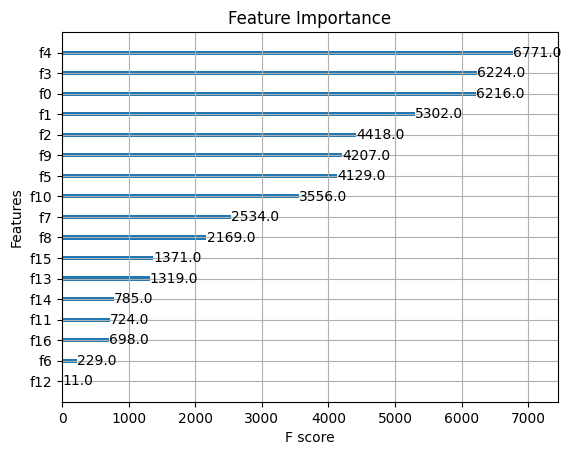

In [64]:
# # Feature Scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Train-Test Split
xtrain, xtest, ytrain, ytest = train_test_split(X_scaled, y, train_size=0.85, random_state=0)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, train_size=0.8, random_state=0)

# XGBoost DMatrix
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xval, label=yval)
dtest = xgb.DMatrix(xtest, label=ytest)

# Cross-Validation and Hyperparameter Tuning
def get_model_rmse(params):
    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')],
                      early_stopping_rounds=10, verbose_eval=0)
    preds = model.predict(dval)
    rmse = mean_squared_error(yval, preds, squared=False)  # Calculate RMSE
    return rmse

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
    max_depth = trial.suggest_int('max_depth', 4, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)  # New parameter
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # New parameter
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)  # New parameter
    l1_reg = trial.suggest_loguniform('alpha', 1e-5, 1.0)
    l2_reg = trial.suggest_loguniform('lambda', 1e-5, 1.0)

    params = {
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'alpha': l1_reg,
        'lambda': l2_reg,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    }

    return get_model_rmse(params)

# Optimize Hyperparameters
study = optuna.create_study()
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Train the final model with the best parameters
best_params = study.best_params
best_model = xgb.train(best_params, dtrain, num_boost_round=100, evals=[(dval, 'eval')],
                        early_stopping_rounds=10, verbose_eval=0)

# Predictions and Evaluation
ypred = best_model.predict(dtest)
r2 = r2_score(ytest, ypred)
rmse = mean_squared_error(ytest, ypred, squared=False)

print("R^2 Score: {:.4f}".format(r2))
print("RMSE: {:.4f}".format(rmse))

# Feature Importance Plot
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()


NameError: name 'X_train' is not defined